In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import cv2

from sklearn import model_selection
from PIL import Image
from skimage import exposure

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import logging
import sys

# Configura el logging
log_format = '[%(process)d]\t%(asctime)s %(levelname)s: %(message)s'
logging.basicConfig(format=log_format, level=logging.INFO, datefmt="%H:%M:%S",
                    handlers=[logging.StreamHandler(sys.stdout)])

# Datos

In [4]:
path = '/home/mr1142/Documents/Data/NIH'

In [5]:
df = pd.read_csv(os.path.join(path, 'Data_Entry_2017.csv'))
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## Labels

In [6]:
labels = np.unique(df['Finding Labels'])
labels = '|'.join(labels)
labels = labels.split('|')
labels = np.unique(labels).tolist()

In [7]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [8]:
for lab in labels:
    df[lab] = pd.NA

In [9]:
def fill_label(information, label):
    positive_labels = information.split('|')
    if label in positive_labels:
        return 1
    return 0

In [10]:
for lab in labels:
    df[lab] = list(map(lambda x: fill_label(x, lab), df['Finding Labels'].tolist()))

In [11]:
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00017524_005.png,Atelectasis|Pneumothorax,5,17524,47,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1
1,00026943_001.png,No Finding,1,26943,71,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
2,00001568_006.png,No Finding,6,1568,43,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
3,00016605_000.png,No Finding,0,16605,29,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
4,00014255_000.png,No Finding,0,14255,38,F,PA,2762,2633,0.143,...,0,0,0,0,0,1,0,0,0,0


In [12]:
print(sum(df.Pneumonia == 1))
print(sum(df['No Finding'] == 1))

1431
60361


In [13]:
n = 200

In [14]:
neumo = df[df.Pneumonia == 1][0:n]
normal = df[df['No Finding'] == 1][0:n]

In [15]:
df = pd.concat([neumo, normal]).reset_index(drop = True)
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00019994_003.png,Atelectasis|Infiltration|Pneumonia,3,19994,62,F,PA,2992,2991,0.143000,...,0,0,0,1,0,0,0,0,1,0
1,00001906_004.png,Pneumonia,4,1906,44,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,1,0
2,00010509_003.png,Pneumonia,3,10509,59,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,1,0
3,00006519_016.png,Edema|Pneumonia,16,6519,59,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,1,0
4,00029628_000.png,No Finding,0,29628,35,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0


## Imagenes

Antes de pasar al modelo vamos a aplicar la segmentación.

1. **Cargamos la imagen**
    - La pasamos a B&N
    - La pasamos al tamaño (pixel, pixel)
    - Le añadimos un eje


2. **La normalizamos**

Ahora la imagen está preparada para entrar en el modelo de segmentación

3. **Extraemos la mascara**


4. **Aplicamos la mascara**
    - Hacemos desenfoque gausiano sobre la mascara
    - La pasamos a B&N
    - Binarizamos (> 0.3 pasa a 1 y el resto a 0)
    
Da error al aplicar el clahe

In [16]:
pixels = 256

In [17]:
new_model = tf.keras.models.load_model('/home/mr1142/Documents/Data/models/unet.h5')

# lee la imagen, la pasa a byn, la pasa al tamaño definido y le añade un axis
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img


# normaliza la imagen mediante media y sd
def normalize(img):
    return (img - np.mean(img))/ np.std(img)


# le aplica una mascara a la imagen
def apply_mask(img, mask):
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask[mask>0.3]=1
    img[mask!=1]=0
    return img


# le aplica clahe a la imagen
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 20)
    final_img = clahe.apply(img)
    return final_img

In [18]:
# coge una imagen, la carga, la normaliza, calcula su mascara, la aplica y le aplica clahe
def get_maskered_img(path, folder, img):
    img = read_img(path, folder, img)
    img = normalize(img)
    mask = new_model.predict(img[np.newaxis,...])[0,...]
    img = apply_mask(img, mask)
    return img

Cargo todas las imagenes y les aplico todos los filtros

In [19]:
def charge_ims(img_list, pix):
    names = []
    imgs = []
    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    # De todas las imagenes que quiero cargar miro cuantas hay en cada carpeta y las cargo
    for folder in subfolders:
        print(folder)
        folder_images = os.listdir(os.path.join(folder, 'images'))
        this_folder_imgs = set(img_list).intersection(folder_images)
        names = names + list(this_folder_imgs)
        for im in this_folder_imgs:
            print(im)
            imgs.append(get_maskered_img(folder, 'images', im))
    return {'name': names, 'imgs': imgs}

In [20]:
imgs_dict = charge_ims(df['Image Index'], pixels)

/home/mr1142/Documents/Data/NIH/images_001
00000815_001.png
00000976_002.png
00000407_000.png
00000310_001.png
00001267_001.png
00000468_029.png
00000150_002.png
00000193_019.png
00000798_039.png
00000324_012.png
00001247_009.png
00000116_030.png
00000915_005.png
00001054_002.png
00000772_002.png
00001324_000.png
00000061_012.png
00000506_016.png
00000261_007.png
00000218_000.png
00000798_020.png
00000583_034.png
/home/mr1142/Documents/Data/NIH/images_002
00002529_022.png
00001958_005.png
00001736_010.png
00001962_000.png
00002182_007.png
00003640_004.png
00001837_002.png
00003837_006.png
00001850_002.png
00003028_057.png
00001911_002.png
00002898_000.png
00003789_000.png
00002275_018.png
00001735_002.png
00001872_004.png
00002634_000.png
00001906_004.png
00002262_001.png
00001745_001.png
00002300_052.png
00001637_001.png
00001629_006.png
00003610_020.png
00002275_019.png
00003043_000.png
00002576_010.png
00001993_000.png
00001806_002.png
00002407_001.png
00003369_012.png
00001568_006.

Reordeno las imagenes en un array

In [22]:
images = np.zeros((len(df), pixels, pixels, 1))
for i in range(len(df)):
    index = [j for j in range(len(imgs_dict['name'])) if imgs_dict['name'][j] == df['Image Index'][i]]
    images[i,...] = imgs_dict['imgs'][index[0]]

In [23]:
images.shape

(400, 256, 256, 1)

## X e Y

In [24]:
Y = np.array(df['Pneumonia'])
X = images

In [25]:
neumo = X[Y == 1]
norm = X[Y == 0]

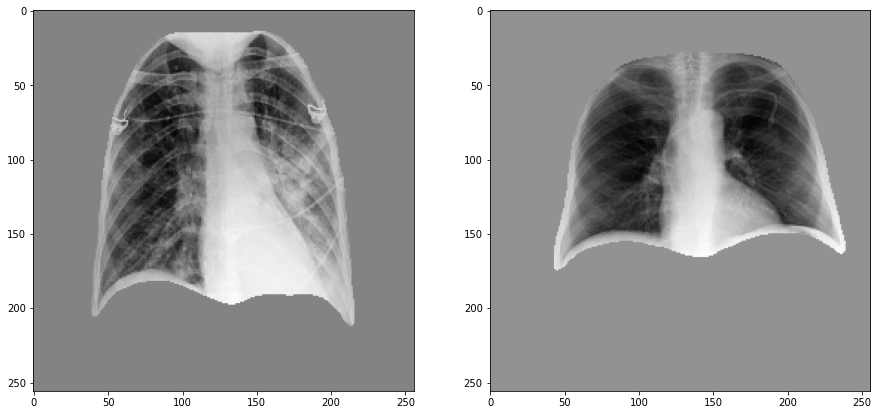

In [146]:
f, ax = plt.subplots(1,2, figsize=(15,15)) 
i = np.random.randint(0, len(neumo))
ax[0].imshow(neumo[i], cmap = 'gray')
ax[1].imshow(norm[i], cmap = 'gray')
f.show()

In [27]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y )

# Modelo

## Red preentrenada EfficienNet B3

In [28]:
input_shape = (pixels,pixels,3)
conv_base = EfficientNetB3(weights="imagenet", include_top=False, input_shape=input_shape)

In [29]:
print(len(conv_base.layers))
print(len(conv_base.trainable_variables))

384
338


## Completo el modelo

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(pixels,pixels,1), activation='elu', name = 'conv_inicial'))
model.add(conv_base)
model.add(layers.Conv2D(32,3, padding='same', input_shape=(8,8,1280), activation='selu', name = 'conv_posterior'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding='same', name = 'first_pooling'))
model.add(layers.Conv2D(64,3, padding='same', input_shape=(4,4,1280), activation='selu', name = 'last_convolution'))
model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
model.add(layers.Dropout(0.2, name="dropout_out"))
model.add(layers.Dense(1, activation="sigmoid", name="fc_out"))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 256, 256, 3)       30        
_________________________________________________________________
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
conv_posterior (Conv2D)      (None, 8, 8, 32)          442400    
_________________________________________________________________
first_pooling (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
last_convolution (Conv2D)    (None, 4, 4, 64)          18496     
_________________________________________________________________
general_max_pooling (GlobalM (None, 64)                0         
_________________________________________________________________
dropout_out (Dropout)        (None, 64)                0

## Callback

In [32]:
log_dir = "/home/mr1142/Documents/Data/logs/fit/image_class_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

# Entrenamiento

## Hiperparametros

In [33]:
lr = 0.05
opt = tf.keras.optimizers.Adam(learning_rate = lr)
loss = loss = 'binary_crossentropy'
met = ['BinaryAccuracy', 'Precision', 'AUC']

In [34]:
batch = 16
epoch = 500

### Especificación por capas

In [35]:
conv_base.trainable = True

Entrenamos desde la capa 300

In [36]:
fine_tune_at = 300

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [37]:
print(len(model.layers))
print(len(model.trainable_variables))

8
83


In [38]:
# opt = [opt_base, tf.keras.optimizers.Adam(learning_rate = lr/100)]
# optimizers_and_layers = [(opt[0], model.layers[0]),
#                          (opt[1], model.layers[1]),
#                          (opt[0], model.layers[2:])]
# opt = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

### Compilación

In [39]:
model.compile(optimizer=opt, loss = loss , metrics = met)

### Entrenamiento

In [40]:
history = model.fit(X_train,Y_train,
                    batch_size = batch,
                    epochs = epoch,
                    callbacks = tensorboard_callback,
                    shuffle = True,
                    validation_split = 0.2)

Epoch 1/500
14/14 [==============================] - 138s 4s/step - loss: 114.4188 - binary_accuracy: 0.4637 - precision: 0.4176 - auc: 0.4792 - val_loss: 149088534528.0000 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/500
14/14 [==============================] - 3s 253ms/step - loss: 1.9435 - binary_accuracy: 0.4063 - precision: 0.3457 - auc: 0.4048 - val_loss: 1544444544.0000 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 3/500
14/14 [==============================] - 3s 227ms/step - loss: 0.8755 - binary_accuracy: 0.5492 - precision: 0.4610 - auc: 0.4745 - val_loss: 20796978.0000 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 4/500
14/14 [==============================] - 3s 237ms/step - loss: 0.8088 - binary_accuracy: 0.5363 - precision: 0.4530 - auc: 0.5745 - val_loss: 1177034.6250 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 5/500
14/14 

14/14 [==============================] - 3s 230ms/step - loss: 0.7958 - binary_accuracy: 0.4694 - precision: 0.4339 - auc: 0.4792 - val_loss: 0.8457 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 36/500
14/14 [==============================] - 3s 219ms/step - loss: 0.7928 - binary_accuracy: 0.4722 - precision: 0.3945 - auc: 0.5141 - val_loss: 0.7325 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 37/500
14/14 [==============================] - 3s 217ms/step - loss: 0.7306 - binary_accuracy: 0.5509 - precision: 0.5973 - auc: 0.5964 - val_loss: 0.8387 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 38/500
14/14 [==============================] - 3s 238ms/step - loss: 0.7730 - binary_accuracy: 0.4604 - precision: 0.3468 - auc: 0.4930 - val_loss: 0.6615 - val_binary_accuracy: 0.6429 - val_precision: 0.6429 - val_auc: 0.5000
Epoch 39/500
14/14 [==============================] - 3s 224ms/st

Epoch 70/500
14/14 [==============================] - 3s 244ms/step - loss: 0.7375 - binary_accuracy: 0.5085 - precision: 0.3378 - auc: 0.4367 - val_loss: 0.6521 - val_binary_accuracy: 0.6429 - val_precision: 0.6429 - val_auc: 0.5000
Epoch 71/500
14/14 [==============================] - 3s 238ms/step - loss: 0.8157 - binary_accuracy: 0.4749 - precision: 0.4588 - auc: 0.4372 - val_loss: 0.8769 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 72/500
14/14 [==============================] - 3s 247ms/step - loss: 0.7880 - binary_accuracy: 0.5233 - precision: 0.3610 - auc: 0.5059 - val_loss: 0.6863 - val_binary_accuracy: 0.6429 - val_precision: 0.6429 - val_auc: 0.5000
Epoch 73/500
14/14 [==============================] - 3s 237ms/step - loss: 0.7809 - binary_accuracy: 0.4874 - precision: 0.4879 - auc: 0.4778 - val_loss: 0.8115 - val_binary_accuracy: 0.3571 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 74/500
 8/14 [================>.............] - ET

KeyboardInterrupt: 